In [109]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from pybedtools import BedTool
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter, deque
from functools import reduce, partial
import re
from xopen import xopen
import glob
from plotting_utils import figure_path, label_sample
from multiprocessing import Pool
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
plasma_miRNA = \
"""hsa-let-7a-1	hsa-let-7a-2	hsa-let-7a	hsa-miR-148a
hsa-miR-221	hsa-miR-338-3p	hsa-miR-103a-1
hsa-let-7b	hsa-miR-148b	hsa-miR-222	hsa-miR-339-3p
hsa-let-7b∗	hsa-miR-150	hsa-miR-223	hsa-miR-342-3p
hsa-let-7d	hsa-miR-151-5p	hsa-miR-223∗	hsa-miR-363
hsa-let-7d∗	hsa-miR-152	hsa-miR-23a	hsa-miR-374b
hsa-let-7f-1	hsa-let-7f	hsa-miR-15a	hsa-miR-23b	hsa-miR-375
hsa-let-7g	hsa-miR-15b	hsa-miR-24	hsa-miR-378	hsa-miR-24-1
hsa-let-7i	hsa-miR-15b∗	hsa-miR-25	hsa-miR-423-3p	hsa-miR-423
hsa-miR-101	hsa-miR-16-1	hsa-miR-26b	hsa-miR-423-5p
hsa-miR-103	hsa-miR-16-2∗	hsa-miR-27a	hsa-miR-424
hsa-miR-106a	hsa-miR-17	hsa-miR-27b	hsa-miR-425
hsa-miR-106b	hsa-miR-181a	hsa-miR-28-3p	hsa-miR-425∗
hsa-miR-107	hsa-miR-185	hsa-miR-28-5p	hsa-miR-451
hsa-miR-122	hsa-miR-186	hsa-miR-29a	hsa-miR-484
hsa-miR-125a-5p	hsa-miR-18a	hsa-miR-29b	hsa-miR-486-5p
hsa-miR-125b	hsa-miR-18b	hsa-miR-29c	hsa-miR-495
hsa-miR-126	hsa-miR-191	hsa-miR-301a	hsa-miR-502-3p
hsa-miR-128	hsa-miR-192	hsa-miR-30b	hsa-miR-505
hsa-miR-130a	hsa-miR-195	hsa-miR-30c	hsa-miR-532-3p
hsa-miR-133a	hsa-miR-199a-3p	hsa-miR-30d	hsa-miR-532-5p
hsa-miR-139-5p	hsa-miR-199a-5p	hsa-miR-30e	hsa-miR-574-3p
hsa-miR-140-3p	hsa-miR-19a	hsa-miR-30e∗	hsa-miR-584
hsa-miR-140-5p	hsa-miR-19b	hsa-miR-32	hsa-miR-629	hsa-miR-142
hsa-miR-142-3p	hsa-miR-20a	hsa-miR-320a	hsa-miR-652
hsa-miR-142-5p	hsa-miR-20b	hsa-miR-320b	hsa-miR-92a
hsa-miR-143	hsa-miR-21	hsa-miR-324-3p	hsa-miR-93
hsa-miR-144	hsa-miR-210	hsa-miR-324-5p	hsa-miR-93∗
hsa-miR-144∗	hsa-miR-215	hsa-miR-328	hsa-miR-99a
hsa-miR-145	hsa-miR-22	hsa-miR-331-3p	hsa-miR-99b
hsa-miR-146a	hsa-miR-22∗	hsa-miR-335"""

miRNA_list = plasma_miRNA.split()
miRNA_list = map(lambda x: re.sub('^hsa-|miR-|-[35]p$','', x), miRNA_list)
miRNA_list = map(lambda x: 'MIR' + x.upper().replace('T-7','T7').rstrip('∗'), miRNA_list)
plasma_miRNA_list = pd.DataFrame({'name': list(miRNA_list),
                                  'is_plasma':'red'}) \
    .assign(name = lambda d: np.where(d.name.str.contains('LET'),
                                     d.name.str.replace('[0-9]$',''),
                                     d.name))
miRNA_list = plasma_miRNA.split()
miRNA_list = list(map(lambda x: x.strip('∗').lower(), miRNA_list))
plasma_miRNA_list.head()


,name,is_plasma
0,MIRLET7A-,red
1,MIRLET7A-,red
2,MIRLET7A,red
3,MIR148A,red
4,MIR221,red


In [111]:
def genome_miRNA_bed_counting(miRNA_bed, mature, fragment_bed):
    if mature:
        fragment_bed = BedTool(fragment_bed)\
            .filter(lambda x: x.end - x.start < 30)
            
            
    fragments = BedTool(fragment_bed)
    
    
    miRNA_cov = BedTool().coverage(a = miRNA_bed,
              b = fragments,
             s = True, 
             f = 0.1,
             F = 0.8,
             counts=True)
    
    return miRNA_cov\
        .to_dataframe()\
        .sort_values('itemRgb', ascending=False)

        
def miRNA_bed_counting(mature, fragment_bed):
    miRNA_counter = Counter()
    with xopen(fragment_bed) as bed:
        for line in bed:
            fields = line.strip().split('\t')
            if fields[0].startswith('hsa') and fields[5] == "+":
                if int(fields[2])-int(fields[1]) < 30 or not mature:
                    miRNA_counter[fields[0]] +=1
    return miRNA_counter
                
     
def count_miRNA(mature=True):
    sample_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
    sample_files = glob.glob(sample_path + '/*001')
    sample_files = filter(lambda x: re.search('[Qq][cC][fF][0-9]+', x), sample_files)
    sample_files = map(lambda x: x+'/smallRNA/aligned.dedup.bed.gz' , sample_files)
    sample_files = deque(sample_files)
    #print(sample_files)
    count_func = partial(miRNA_bed_counting, mature)
    p = Pool(24)
    miRNA_counts = p.map(count_func, sample_files)
    p.close()
    p.join()
    
    miRNA_counts = reduce(lambda x,y: x+y, miRNA_counts)
    return pd.DataFrame().from_dict(miRNA_counts, orient='index')\
        .reset_index()\
        .rename(columns={'index':'miRNA',
                        0:'miRNA_count'})\
        .sort_values('miRNA_count', ascending=False)

def merge_dfs(x,y):
    return x.merge(y, how='outer')

def make_cpm(df):
    for col in df.columns:
        df[col] = df[col]/df[col].sum() * 1e6
    return df

In [112]:
mature_count = count_miRNA(mature=True)
mature_count.head()

,miRNA,miRNA_count
45,hsa-mir-223,115
14,hsa-mir-1285-1,68
2,hsa-let-7b,66
20,hsa-mir-145,45
36,hsa-mir-196b,31


In [113]:
all_count = count_miRNA(mature=False)
all_count.head()

,miRNA,miRNA_count
18,hsa-mir-1285-1,156
50,hsa-mir-223,119
2,hsa-let-7b,83
24,hsa-mir-145,45
6,hsa-let-7f-1,42


In [114]:
def plot_miRNA(ax,miRNA_df, title):        
    colored_df = miRNA_df.nlargest(20, 'miRNA_count')\
            .assign(plasma = lambda d: np.where(d.miRNA.isin(miRNA_list),
                                               'red','black'))
        
    colored_df.plot.bar('miRNA', 'miRNA_count', 
                  color='steelblue',
                 ax = ax)
    ax.set_title(title, size = 15)
    ax.set_xlabel('miRNA')
    ax.set_ylabel('Read count')
    for xt, color in zip(ax.get_xticklabels(),colored_df.plasma):
        xt.set_color(color)
    ax.legend().set_visible(False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70, rotation_mode = 'anchor', ha = 'right')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Written /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/miRNA_counts.pdf


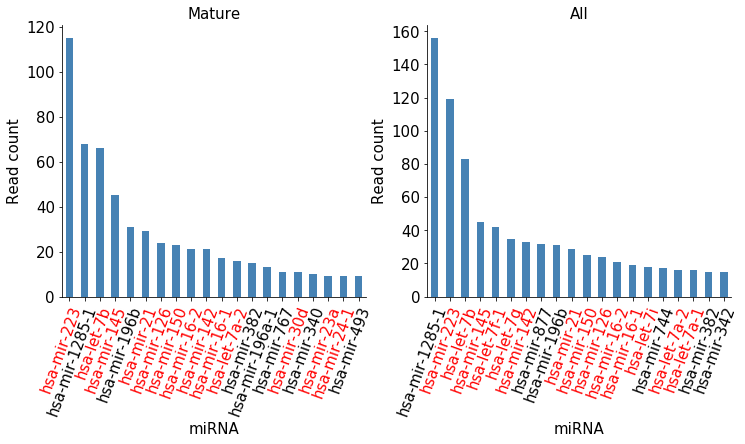

In [115]:
fig = plt.figure(figsize=(12,5))
ax_mature = fig.add_subplot(121)
plot_miRNA(ax_mature, mature_count, 'Mature')

ax_all = fig.add_subplot(122)
plot_miRNA(ax_all, all_count, 'All')
sns.despine()
figurename = figure_path + '/miRNA_counts.pdf' 
fig.savefig(figurename, bbox_inches = 'tight')
print('Written %s' %figurename)

In [121]:
all_count\
    .rename(columns = {'miRNA_count':'all_count'})\
    .merge(mature_count, how ='left')\
    .assign(diff = lambda d: d.all_count - d.miRNA_count)\
    .sort_values('diff', ascending=False)

,miRNA,all_count,miRNA_count,diff
0,hsa-mir-1285-1,156,68.0,88.0
4,hsa-let-7f-1,42,5.0,37.0
7,hsa-mir-877,32,3.0,29.0
5,hsa-let-7g,35,7.0,28.0
14,hsa-let-7i,18,1.0,17.0
2,hsa-let-7b,83,66.0,17.0
15,hsa-mir-744,17,1.0,16.0
6,hsa-mir-142,33,21.0,12.0
17,hsa-let-7a-1,16,4.0,12.0
20,hsa-let-7d,14,3.0,11.0


In [19]:
def plot_miRNA(ax,miRNA_df, title):
    colored_df = miRNA_df\
        .assign(name = lambda d: np.where(d.name.str.contains('LET'),
                                     d.name.str.replace('[0-9]$',''),
                                     d.name))\
        .merge(plasma_miRNA_list, how='left')\
        .fillna('black')\
        .query('itemRgb >0 ')\
        .drop_duplicates()\
        .nlargest(20,'itemRgb')
        
    colored_df.plot.bar('name', 'itemRgb', 
                  color='steelblue',
                 ax = ax)
    ax.set_title(title, size = 15)
    ax.set_xlabel('miRNA')
    ax.set_ylabel('Read count')
    for xt, color in zip(ax.get_xticklabels(),colored_df.is_plasma):
        xt.set_color(color)
    ax.legend().set_visible(False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70, rotation_mode = 'anchor', ha = 'right')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Written /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/miRNA_counts.pdf


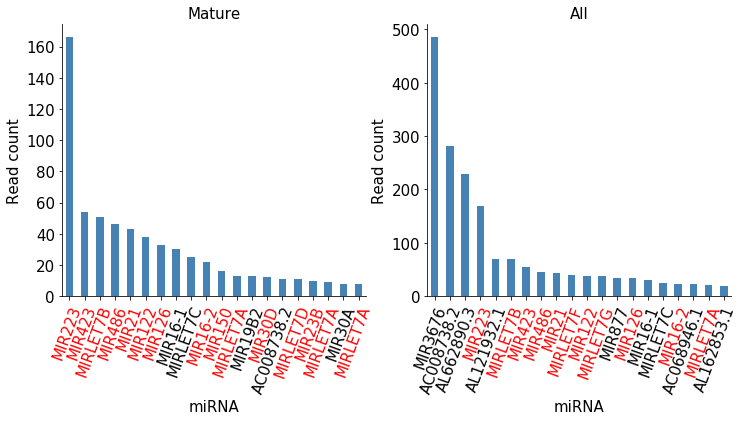

In [20]:
fig = plt.figure(figsize=(12,5))
ax_mature = fig.add_subplot(121)
plot_miRNA(ax_mature, mature_count, 'Mature')

ax_all = fig.add_subplot(122)
plot_miRNA(ax_all, all_count, 'All')
sns.despine()
figurename = figure_path + '/miRNA_counts.pdf' 
fig.savefig(figurename, bbox_inches = 'tight')
print('Written %s' %figurename)

In [14]:
def plot_heatmap(top_n=50, mature=False):
    sample_files = ['unfragmented.bed.gz', 
                'alkaline.bed.gz',
                'all.bed.gz',
                'fragmented.bed.gz']
    all_mirna = []
    for sample_file in sample_files:
        samplename = sample_file.replace('.bed.gz','')
        all_mirna.append(count_miRNA(sample_file=sample_file, mature=mature)\
                        .rename(columns = {'itemRgb':samplename}))
        
    all_mirna_df = reduce(merge_dfs, all_mirna)
    
    plasma_miRNA = set(plasma_miRNA_list.name.values.tolist())

    cpm_df = all_mirna_df\
        .filter(regex='name|frag|alk|all')\
        .set_index('name')\
        .pipe(lambda d: make_cpm(d))\
        .fillna(0)\
        .transform(lambda x: np.log2(x+1))\
        .nlargest(top_n, 'unfragmented')
    p = sns.clustermap(cpm_df, cmap = 'viridis')
    ax = p.ax_heatmap
    ax.set_yticks(range(top_n))
    
    
    yt = ax.set_yticklabels(cpm_df.index[:top_n])
    for yt in ax.get_yticklabels():
        mirna = yt.get_text()
        if 'LET' in mirna:
            mirna = re.sub('[0-9]$','',mirna)
        if yt.get_text() in plasma_miRNA:
            yt.set_color('red')
    return all_mirna_df

***** WARNING: File /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/merged_bed/unfragmented.bed.gz has inconsistent naming convention for record:
gi|23898|emb|X12811.1|	269	386	UMI_1_1	0	+

***** WARNING: File /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/merged_bed/unfragmented.bed.gz has inconsistent naming convention for record:
gi|23898|emb|X12811.1|	269	386	UMI_1_1	0	+

***** WARNING: File /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/merged_bed/alkaline.bed.gz has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	863	1375	UMI_1_1	0	+

***** WARNING: File /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/merged_bed/alkaline.bed.gz has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	863	1375	UMI_1_1	0	+

***** WARNING: File /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/merged_bed/all.bed.gz has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	1445	1481	UMI_1_1	0	+

***** WARNING: File /stor/work/Lambowitz/cdw2854/cfNA/tgirt

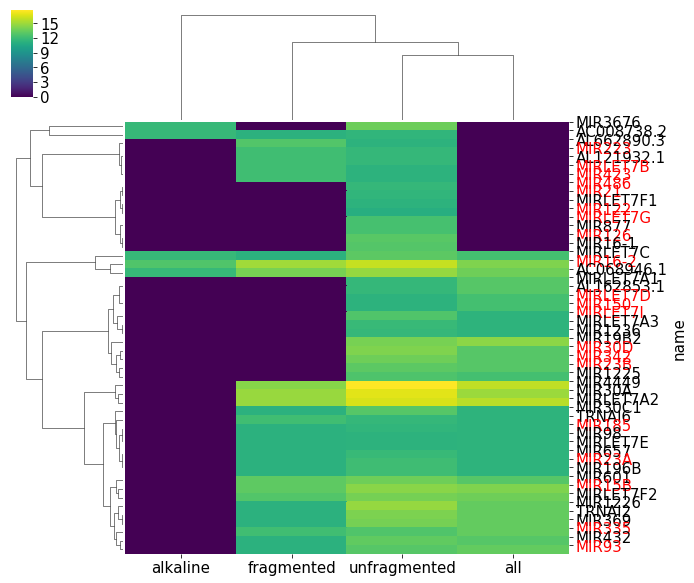

In [15]:
all_mirna_df = plot_heatmap()

***** WARNING: File /tmp/pybedtools.71tas5js.tmp has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	3906	3933	UMI_1_1	0	+

***** WARNING: File /tmp/pybedtools.71tas5js.tmp has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	3906	3933	UMI_1_1	0	+

***** WARNING: File /tmp/pybedtools.jbvrpdyz.tmp has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	27987	28007	UMI_1_1	0	+

***** WARNING: File /tmp/pybedtools.jbvrpdyz.tmp has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	27987	28007	UMI_1_1	0	+

***** WARNING: File /tmp/pybedtools.36pxvrpt.tmp has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	8488	8509	UMI_1_1	0	+

***** WARNING: File /tmp/pybedtools.36pxvrpt.tmp has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	8488	8509	UMI_1_1	0	+

***** WARNING: File /tmp/pybedtools.y0_q4e96.tmp has inconsistent naming convention for record:


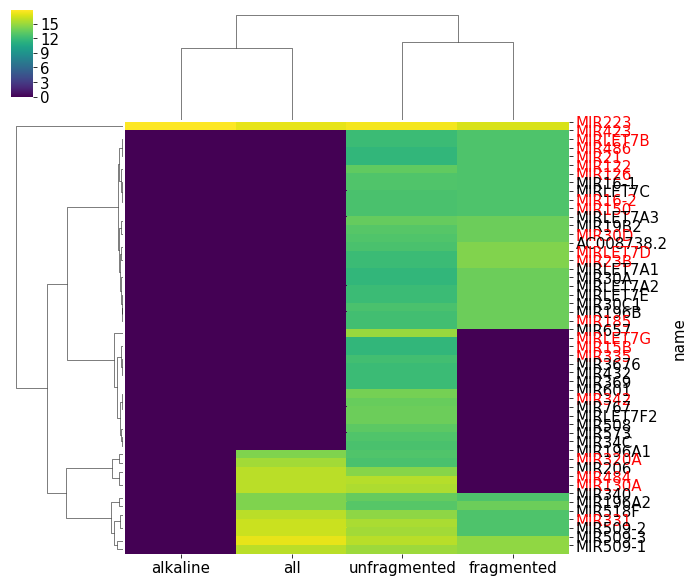

In [16]:
mature_mirna_df = plot_heatmap(mature=True)

In [17]:
def heatmap_miRNA(mirna_df, ax, title):
    top_n = 50
    cpm_df = mirna_df \
        .filter(regex='name|frag|alk|all')\
        .set_index('name')\
        .pipe(lambda d: make_cpm(d))\
        .fillna(0)\
        .nlargest(top_n, 'unfragmented')\
        .transform(lambda x: np.log2(x+1))\
        .filter(regex = 'unfra|all') \
        .rename(columns = label_sample)
    
    plasma_miRNA = set(plasma_miRNA_list.name.values.tolist())


    sns.heatmap(cpm_df, 
            ax = ax,
           cmap = 'viridis')
    ax.set_yticks(np.arange(top_n) + 0.5)
    yt = ax.set_yticklabels(cpm_df.index[:top_n])
    for yt in ax.get_yticklabels():
        mirna = yt.get_text()
        if 'LET' in mirna:
            mirna = re.sub('[0-9]$','',mirna)
        if mirna in plasma_miRNA:
            yt.set_color('red')
        
    ax.set_ylabel('miRNA')
    ax.set_title(title, size=15)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


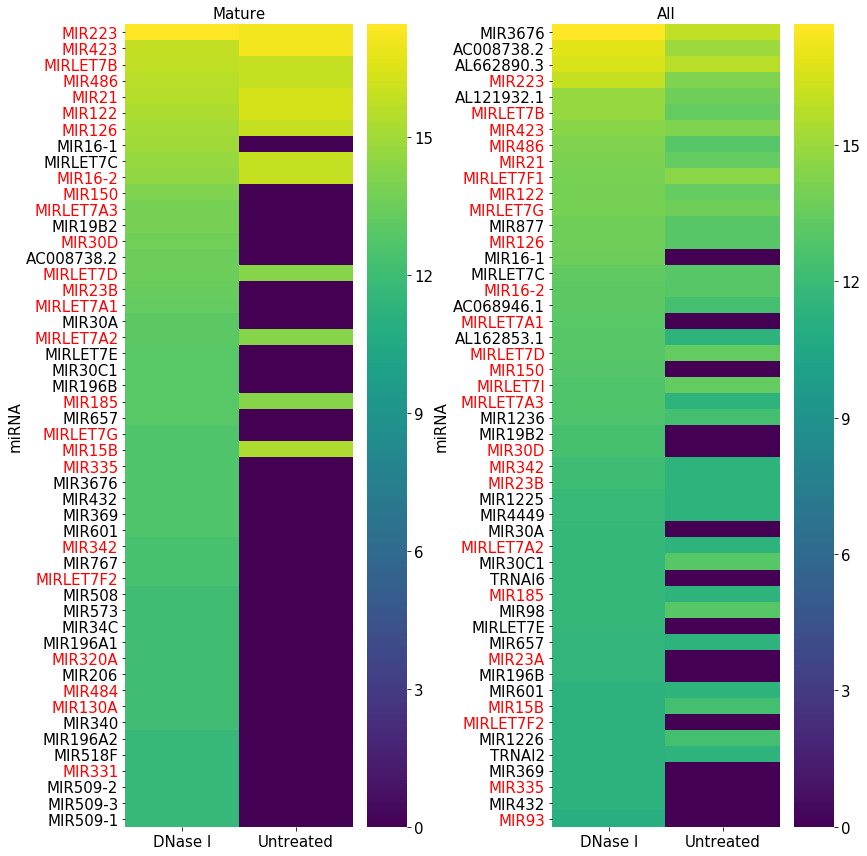

In [18]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

heatmap_miRNA(mature_mirna_df, ax, 'Mature')
heatmap_miRNA(all_mirna_df, ax2, 'All')
fig.tight_layout()